<a href="https://colab.research.google.com/github/makhijakabir/eyeDiseaseDetection/blob/main/eyeDiseaseDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Eye Disease Detection system using Transfer Learning and CNN Approach


##Model Imports & Constants

###Model Imports

In [1]:
%load_ext tensorboard

In [2]:
from numpy.random import seed
seed(888)
from tensorflow.random import set_seed
set_seed(404)

In [3]:
import pandas as pd
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import time
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from tqdm import tqdm

%matplotlib inline

In [4]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

In [6]:
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199

###Constants

In [7]:
img_size = img_size=(200,224)

##Model Concepts

This notebook implements a custom callback to adjust the learning rate during training.
The callback has a parameter dwell. If dwell is set to True, the callback monitors the
validation loss. It keeps track of the lowest validation loss thus far achieved as you run
through each epoch and stores this as the lowest loss and also stores the weights for that
epoch as the best weights. At the end of an epoch the validation loss for that epoch is
compared with the lowest loss. If the validation loss at the end of the current epoch is
less than the lowest loss than it becomes the lowest loss and the weights of the current
epoch become the best weights

If the validation loss at the end of the current epoch is greator than the lowest loss
this implies you have moved to a location in Nspace(N is the number of trainable parameters
on the validation cost function surface that is less favorable(higher cost) than the position
in Nspace defined by the best weights. Therefore why move the models weights to this less
favorable location? Better to reset the models weights to the best weights, then lower the
learning rate and run more epochs. The new learning rate is set to new_lr=current_lr * factor
where factor is a user specified parameter in the instantiation of the callback. By default
it is set to .04 and by default dwell is set to True.

At the end of training the callback always returns your model with the weights set to the
best weights. The callback provides a feature where it periodically queries the user to
either contine and optionally manually specify a new learning rate or halt training.
During training the calback provides useful information on the percent improvement in the
validation loss for each epoch. The is useful to decide when to halt training or manually
specifying a new learning rate.


###Testing the Printing and Colors for exploratory data analysis

####Define a function to print text in specified rgb foreground and background colors

Add some PZAZZ to your printed output with this function
form of the call is: print_in_color(txt_msg, fore_tupple, back_tupple where:

1. txt_msg is the string to be printed out
2. fore_tuple is tuple of the form (r,g,b) specifying the foreground color of the text
3. back_tuple is tuple of the form (r,g,b) specifying the background color of the text

In [8]:
def print_in_color(txt_msg,fore_tupple=(0,255,255),back_tupple=(100,100,100)):
    
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple 
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    # default parameter print in cyan foreground and gray background
    
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
    
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    
    return

# example default print
msg='test of default colors'
print_in_color(msg)

test of default colors



##Data Pre-Processing

Reading in images and creating Train, Test, and Validation Datasets



###Initial Dataset Creation

Reading the initial dataset and dividing various training, testing, and validation datasets along with classifying them into 4 classes 

In [9]:
def make_dataframes(sdir): 
    
    filepaths=[]
    labels=[]
    classlist=sorted(os.listdir(sdir) )       
    
    for klass in classlist:
       
        classpath=os.path.join(sdir, klass)           
        flist=sorted(os.listdir(classpath)) 
        desc=f'{klass:25s}'
        
        for f in tqdm(flist, ncols=130,desc=desc, unit='files', colour='blue'):
            
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(klass)
    
    Fseries=pd.Series(filepaths, name='filepaths')
    Lseries=pd.Series(labels, name='labels')
    
    df=pd.concat([Fseries, Lseries], axis=1) 
    train_df, dummy_df=train_test_split(df, train_size=.7, shuffle=True, random_state=123, stratify=df['labels']) 
    valid_df, test_df=train_test_split(dummy_df, train_size=.5, shuffle=True, random_state=123, stratify=dummy_df['labels']) 
    
    classes=sorted(train_df['labels'].unique())
    class_count=len(classes)
    sample_df=train_df.sample(n=50, replace=False)
    
    # calculate the average image height and with
    ht=0
    wt=0
    count=0
    
    for i in range(len(sample_df)):
        fpath=sample_df['filepaths'].iloc[i]
        
        try:
            img=cv2.imread(fpath)
            h=img.shape[0]
            w=img.shape[1]
            wt +=w
            ht +=h
            count +=1
        
        except:
            pass
    
    have=int(ht/count)
    wave=int(wt/count)
    aspect_ratio=have/wave
    
    print('number of classes in processed dataset= ', class_count)    
    counts=list(train_df['labels'].value_counts())     
    
    print('the maximum files in any class in train_df is ', max(counts), '  the minimum files in any class in train_df is ', min(counts))
    print('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))  
    print('average image height= ', have, '  average image width= ', wave, ' aspect ratio h/w= ', aspect_ratio)    
    
    return train_df, test_df, valid_df, classes, class_count

sdir=r'/content/drive/MyDrive/Colab Notebooks/eyeDisease'
train_df, test_df, valid_df, classes, class_count=make_dataframes(sdir)

normal                   : 100%|███████████████████████████████████████████████████████| 1074/1074 [00:00<00:00, 373522.60files/s]


number of classes in processed dataset=  4
the maximum files in any class in train_df is  768   the minimum files in any class in train_df is  705
train_df length:  2951   test_df length:  633   valid_df length:  633
average image height=  471   average image width=  505  aspect ratio h/w=  0.9326732673267327


###Data Re-Structuring

Reducing the number of images in the training dataset to 300 images per class in total to prevent over-training.

Each class now has 300 images. The number is dynamic and can be redefined using user-input.

Trimming the train_df dataset

In [10]:
def trim(df, max_samples, min_samples, column):
    
    df=df.copy()
    classes=df[column].unique()
    class_count=len(classes)
    length=len(df)
    
    print ('dataframe initially is of length ',length, ' with ', class_count, ' classes')
    groups=df.groupby(column)    
    trimmed_df = pd.DataFrame(columns = df.columns)
    groups=df.groupby(column)
    
    for label in df[column].unique(): 
        
        group=groups.get_group(label)
        count=len(group)    
        
        if count > max_samples:
            
            sampled_group=group.sample(n=max_samples, random_state=123,axis=0)
            trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
        
        else:
           
            if count>=min_samples:
              
                sampled_group=group        
                trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
    
    print('after trimming, the maximum samples in any class is now ',max_samples, ' and the minimum samples in any class is ', min_samples)
    
    classes=trimmed_df[column].unique()# return this in case some classes have less than min_samples
    class_count=len(classes) # return this in case some classes have less than min_samples
    length=len(trimmed_df)
    
    print ('the trimmed dataframe now is of length ',length, ' with ', class_count, ' classes')
    
    return trimmed_df, classes, class_count

max_samples=300
min_samples=300
column='labels'
train_df, classes, class_count=trim(train_df, max_samples, min_samples, column)

dataframe initially is of length  2951  with  4  classes
after trimming, the maximum samples in any class is now  300  and the minimum samples in any class is  300
the trimmed dataframe now is of length  1200  with  4  classes


###Train, Test, and Validation Creation

In [11]:
def make_gens(batch_size, train_df, test_df, valid_df, img_size):
    
    trgen=ImageDataGenerator()
    t_and_v_gen=ImageDataGenerator()

    msg='{0:70s} for train generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    
    train_gen=trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
    
    msg='{0:70s} for valid generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    
    valid_gen=t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)
    
    # for the test_gen we want to calculate the batch size and test steps such that batch_size X test_steps= number of samples in test set
    # this insures that we go through all the sample in the test set exactly once.
    
    length=len(test_df)
    test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
    test_steps=int(length/test_batch_size)
    
    msg='{0:70s} for test generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    
    test_gen=t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)
    
    # from the generator we can get information we will need later
    
    classes=list(train_gen.class_indices.keys())
    class_indices=list(train_gen.class_indices.values())
    class_count=len(classes)
    labels=test_gen.labels
    
    print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)
    return train_gen, test_gen, valid_gen, test_batch_size, test_steps, classes


batch_size=30
train_gen, test_gen, valid_gen, test_batch_size, test_steps, classes=make_gens(batch_size, train_df, test_df, valid_df, img_size)

Found 1200 validated image filenames belonging to 4 classes.
Found 633 validated image filenames belonging to 4 classes.
Found 633 validated image filenames belonging to 4 classes.
test batch size:  3   test steps:  211  number of classes :  4


##Data Exploration

###Image Exploration

Print examples of training images using functions

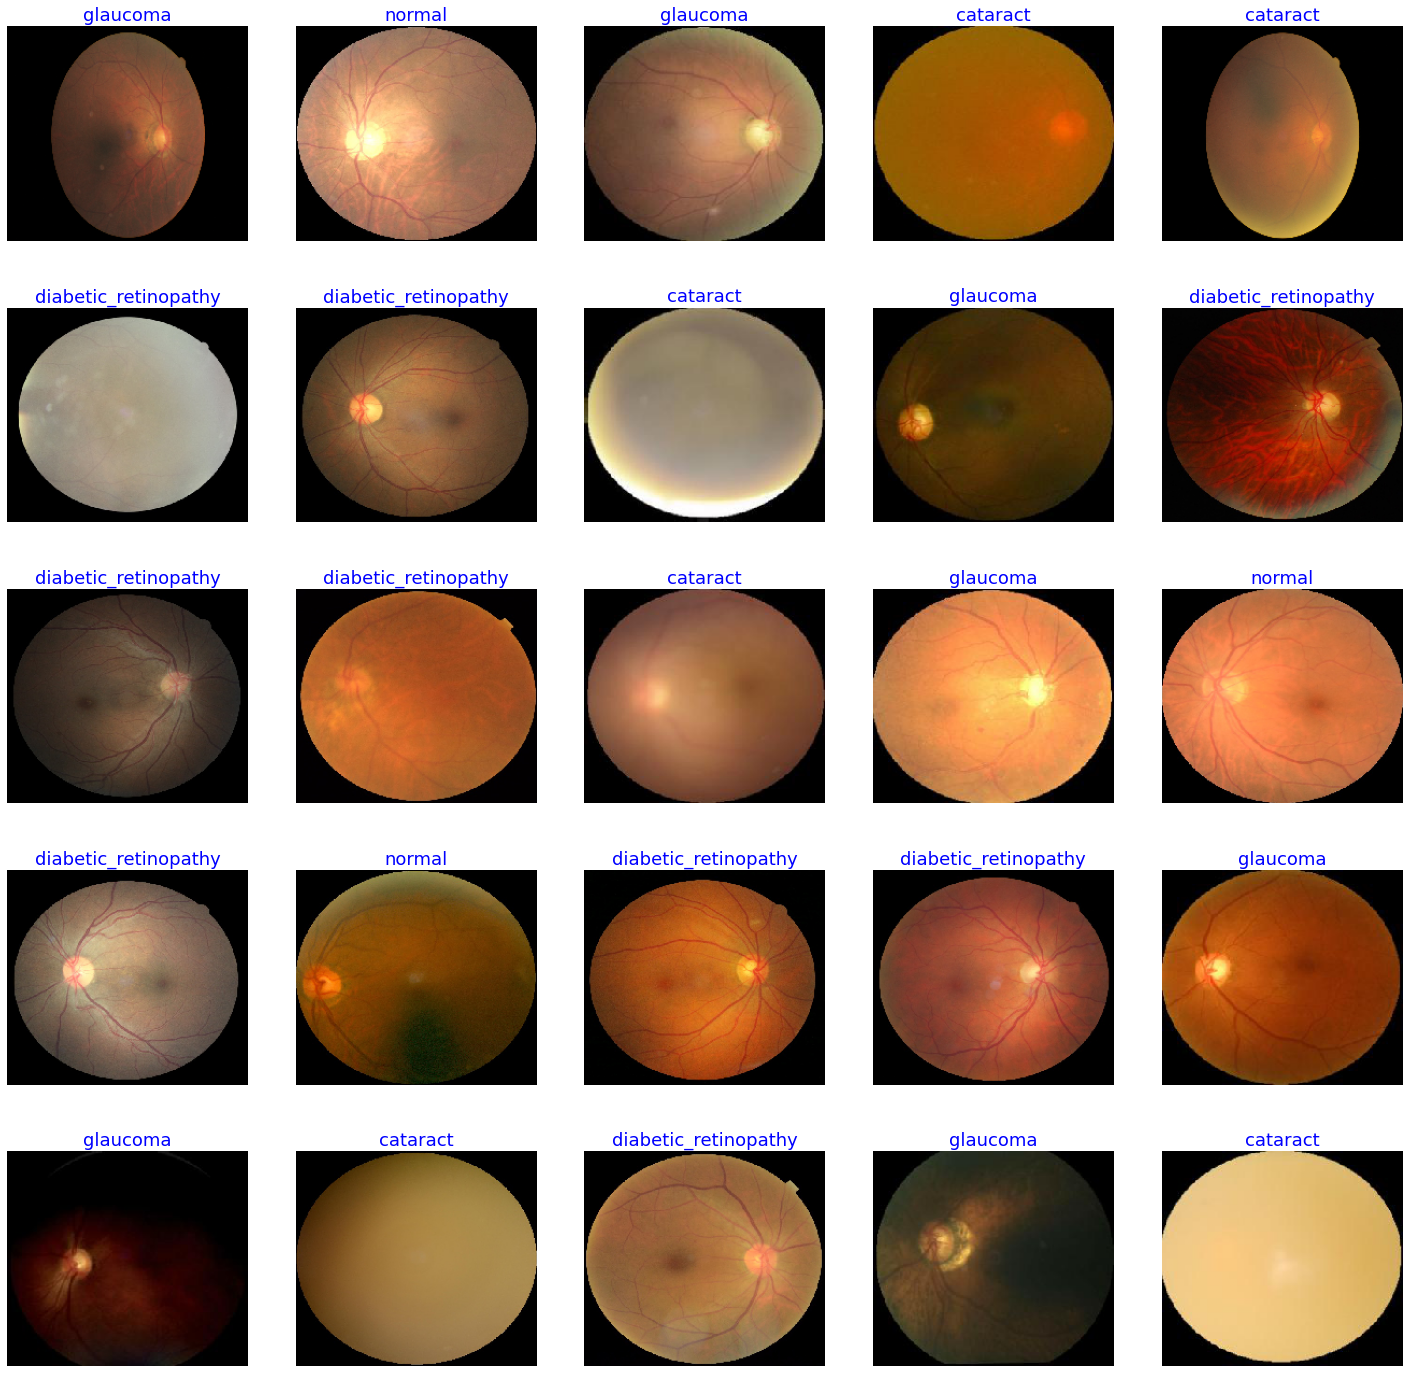

In [12]:
def show_image_samples(gen ):

    t_dict=gen.class_indices
    classes=list(t_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    
    plt.figure(figsize=(25, 25))
    length=len(labels)
    
    if length<25:   #show maximum of 25 images
    
        r=length
    
    else:
    
        r=25
    
    for i in range(r):        
    
        plt.subplot(5, 5, i + 1)
        image=images[i] /255       
    
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
    
        plt.title(class_name, color='blue', fontsize=18)
    
        plt.axis('off')
    
    plt.show()
    
show_image_samples(train_gen )

##Model Building

###EfficientNetB3

Create a model using transfer learning with EfficientNetB3

NOTE: experts advise you make the base model initially not trainable when you do transfer learning.

Then train for some number of epochs then fine tune model by making base model trainable and run more epochs

Making the base model trainable from the outset leads to faster convegence and a lower validation loss

for the same number of total epochs! Insure you initialize the transfer model with imagenet weights

In [13]:
def make_model(img_size, lr, mod_num=3):  
    
    img_shape=(img_size[0], img_size[1], 3)
    
    if mod_num == 0:
        base_model=tf.keras.applications.efficientnet.EfficientNetB0(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
        msg='Created EfficientNet B0 model'
    
    elif mod_num == 3:
        base_model=tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
        msg='Created EfficientNet B3 model'
    
    elif mod_num == 5:
        base_model=tf.keras.applications.efficientnet.EfficientNetB5(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
        msg='Created EfficientNet B5 model'
        
    else:
        base_model=tf.keras.applications.efficientnet.EfficientNetB7(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
        msg='Created EfficientNet B7 model'   
   
    
    base_model.trainable=True
    
    x = base_model.output
    x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
    x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006), bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
    x = Dropout(rate=.4, seed=123)(x)       
    
    output=Dense(class_count, activation='softmax')(x)
    
    model=Model(inputs=base_model.input, outputs=output)
    model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy']) 
    
    msg = msg + f' with initial learning rate set to {lr}'
    
    print_in_color(msg)
    
    return model

lr=.001
model=make_model(img_size, lr) # using B3 model by default


43941136/43941136 [==============================] - 3s 0us/step
Created EfficientNet B3 model with initial learning rate set to 0.001



###Creating Callbacks

Create a custom Keras callback to continue and optionally set LR or halt training The LR_ASK callback is a convenient callback that allows you to continue training for ask_epoch more epochs or to halt training.

If you elect to continue training for more epochs you are given the option to retain the current learning rate (LR) or to enter a new value for the learning rate. The form of use is:

ask=LR_ASK(model,epochs, ask_epoch) where:

model is a string which is the name of your compiled model.

epochs is an integer which is the number of epochs to run specified in model.fit

ask_epoch is an integer. If ask_epoch is set to a value say 5 then the model will train for 5 epochs. then the user is ask to enter H to halt training, or enter an inter value. For example if you enter 4 training will continue for 4 more epochs to epoch 9 then you will be queried again. Once you enter an integer value you are prompted to press ENTER to continue training using the current learning rate or to enter a new value for the learning rate.

dwell is a boolean. If set to true the function compares the validation loss for the current tp the lowest validation loss thus far achieved. If the validation loss for the current epoch is larger then learning rate is automatically adjust by the formulanew_lr=lr * factor where factor is a float between 0 and 1. The motivation here is that if the validatio loss increased we have moved to a point in Nspace on the cost functiob surface that if less favorable(higher cost) than for the epoch with the lowest cost. So the model is loaded with the weights from the epoch with the lowest loss and the learning rate is reduced.

At the end of training the model weights are set to the weights for the epoch that achieved the lowest validation loss.

In [14]:
class LR_ASK(keras.callbacks.Callback):
    

    def __init__ (self, model, epochs,  ask_epoch, dwell=True, factor=.4): # initialization of the callback
        
        super(LR_ASK, self).__init__()
        
        self.model=model               
        self.ask_epoch=ask_epoch
        self.epochs=epochs
        self.ask=True # if True query the user on a specified epoch
        self.lowest_vloss=np.inf
        self.lowest_aloss=np.inf
        self.best_weights=self.model.get_weights() # set best weights to model's initial weights
        self.best_epoch=1
        self.plist=[]
        self.alist=[]
        self.dwell= dwell
        self.factor=factor


    def get_list(self): # define a function to return the list of % validation change
        return self.plist, self.alist
    

    def on_train_begin(self, logs=None): # this runs on the beginning of training
        
        if self.ask_epoch == 0: 
            print('you set ask_epoch = 0, ask_epoch will be set to 1', flush=True)
            self.ask_epoch=1
        
        if self.ask_epoch >= self.epochs: # you are running for epochs but ask_epoch>epochs
            print('ask_epoch >= epochs, will train for ', epochs, ' epochs', flush=True)
            self.ask=False # do not query the user
        
        if self.epochs == 1:
            self.ask=False # running only for 1 epoch so do not query user
        
        else:
            msg =f'Training will proceed until epoch {ask_epoch} then you will be asked to' 
            print_in_color(msg )
            msg='enter H to halt training or enter an integer for how many more epochs to run then be asked again'
            print_in_color(msg)
            
            if self.dwell:
                msg='learning rate will be automatically adjusted during training'
                print_in_color(msg, (0,255,0))
        
        self.start_time= time.time() # set the time at which training started
       

    def on_train_end(self, logs=None):   # runs at the end of training  
        
        msg=f'loading model with weights from epoch {self.best_epoch}'
        print_in_color(msg, (0,255,255))
        model.set_weights(self.best_weights) # set the weights of the model to the best weights
        tr_duration=time.time() - self.start_time   # determine how long the training cycle lasted         
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print_in_color (msg) # print out training duration time
        

    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        
        vloss=logs.get('val_loss')  # get the validation loss for this epoch
        aloss=logs.get('loss')
        
        if epoch >0:
            deltav = self.lowest_vloss- vloss 
            pimprov=(deltav/self.lowest_vloss) * 100 
            self.plist.append(pimprov)
            deltaa=self.lowest_aloss-aloss
            aimprov=(deltaa/self.lowest_aloss) * 100
            self.alist.append(aimprov)
        
        else:
            pimprov=0.0 
            aimprov=0.0
        
        if vloss< self.lowest_vloss:
            self.lowest_vloss=vloss
            self.best_weights=self.model.get_weights() # set best weights to model's initial weights
            self.best_epoch=epoch + 1            
            msg=f'\n validation loss of {vloss:7.4f} is {pimprov:7.4f} % below lowest loss, saving weights from epoch {str(epoch + 1):3s} as best weights'
            print_in_color(msg, (0,255,0)) # green foreground
        
        else: # validation loss increased
            pimprov=abs(pimprov)
            msg=f'\n validation loss of {vloss:7.4f} is {pimprov:7.4f} % above lowest loss of {self.lowest_vloss:7.4f} keeping weights from epoch {str(self.best_epoch)} as best weights'
            print_in_color(msg, (255,255,0)) # yellow foreground
            
            if self.dwell: # if dwell is True when the validation loss increases the learning rate is automatically reduced and model weights are set to best weights
                lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
                new_lr=lr * self.factor
                msg=f'learning rate was automatically adjusted from {lr:8.6f} to {new_lr:8.6f}, model weights set to best weights'
                print_in_color(msg) # cyan foreground
                tf.keras.backend.set_value(self.model.optimizer.lr, new_lr) # set the learning rate in the optimizer
                model.set_weights(self.best_weights) # set the weights of the model to the best weights      
                
        if aloss< self.lowest_aloss:
            self.lowest_aloss=aloss        
        
        if self.ask: # are the conditions right to query the user?
            
            if epoch + 1 ==self.ask_epoch: # is this epoch the one for quering the user?
                msg='\n Enter H to end training or  an integer for the number of additional epochs to run then ask again'
                print_in_color(msg) # cyan foreground
                ans=input()
                
                if ans == 'H' or ans =='h' or ans == '0': # quit training for these conditions
                    msg=f'you entered {ans},  Training halted on epoch {epoch+1} due to user input\n'
                    print_in_color(msg)
                    self.model.stop_training = True # halt training
            
                else: # user wants to continue training
                    self.ask_epoch += int(ans)
            
                    if self.ask_epoch > self.epochs:
                        print('\nYou specified maximum epochs of as ', self.epochs, ' cannot train for ', self.ask_epoch, flush =True)
            
                    else:
                        msg=f'you entered {ans} Training will continue to epoch {self.ask_epoch}'
                        print_in_color(msg) # cyan foreground
            
                        if self.dwell==False:
                            lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
                            msg=f'current LR is  {lr:8.6f}  hit enter to keep  this LR or enter a new LR'
                            print_in_color(msg) # cyan foreground
                            ans=input(' ')
            
                            if ans =='':
                                msg=f'keeping current LR of {lr:7.5f}'
                                print_in_color(msg) # cyan foreground
            
                            else:
                                new_lr=float(ans)
                                tf.keras.backend.set_value(self.model.optimizer.lr, new_lr) # set the learning rate in the optimizer
                                msg=f' changing LR to {ans}'
                                print_in_color(msg) # cyan foreground

###Instantiation

In [15]:
epochs=40
ask_epoch=5
ask=LR_ASK(model, epochs,  ask_epoch)
callbacks=[ask]


##Model Training

Note: unlike how you are told it is BETTER to make the base model trainable from the outset if you are doing transfer learning.

The model will converge faster and have a lower validation losss. Ensure you initialize the transfer model with imagenet weights. 

I have done a lot of testing running both ways hand have always found this to be true.

In [16]:
history=model.fit(x=train_gen,  epochs=epochs, verbose=1, callbacks=callbacks,  validation_data=valid_gen, validation_steps=None,  shuffle=False,  initial_epoch=0)

Training will proceed until epoch 5 then you will be asked to

enter H to halt training or enter an integer for how many more epochs to run then be asked again

learning rate will be automatically adjusted during training

Epoch 1/40
40/40 [==============================] - ETA: 0s - loss: 8.1959 - accuracy: 0.7000 
 validation loss of 13.3141 is  0.0000 % below lowest loss, saving weights from epoch 1   as best weights

40/40 [==============================] - 990s 25s/step - loss: 8.1959 - accuracy: 0.7000 - val_loss: 13.3141 - val_accuracy: 0.4913
Epoch 2/40
40/40 [==============================] - ETA: 0s - loss: 6.6420 - accuracy: 0.8917
 validation loss of  7.9560 is 40.2436 % below lowest loss, saving weights from epoch 2   as best weights

40/40 [==============================] - 29s 720ms/step - loss: 6.6420 - accuracy: 0.8917 - val_loss: 7.9560 - val_accuracy: 0.6509
Epoch 3/40
40/40 [==============================] - ETA: 0s - loss: 5.6417 - accuracy: 0.9375
 validation loss